In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from typing import Optional, Dict, Any

global settings

In [8]:
# Use a browser-like User-Agent to avoid being blocked by Steam
HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/124.0 Safari/537.36"
    )
}

Scrape Steam Store Top Sellers

In [9]:
def scrape_steam_topsellers(n_pages: int = 10) -> pd.DataFrame:
    """
    Scrape the Steam Store 'Top Sellers' search pages.

    Parameters
    ----------
    n_pages : int, optional
        Number of pages to scrape (page=1, 2, ..., n_pages).
        Each page contains a list of top-selling games.

    Returns
    -------
    pandas.DataFrame
        DataFrame with one row per game and the following columns:
        - 'appid' : int
            Steam application ID of the game.
        - 'name' : str or None
            Game title as shown on the search page.
        - 'search_price_raw' : str
            Raw price text displayed on the search page
            (e.g., "Free To Play", "$29.99", "$59.99 $39.99").
    """
    rows = []

    for page in range(1, n_pages + 1):
        url = f"https://store.steampowered.com/search/?filter=topsellers&page={page}"
        print("Fetching:", url)

        resp = requests.get(url, headers=HEADERS, timeout=15)
        if resp.status_code != 200:
            print("  -> Status code", resp.status_code, "- skipping this page.")
            continue

        soup = BeautifulSoup(resp.text, "html.parser")

        # Each search result is an <a> tag with this class
        for a in soup.select("a.search_result_row"):
            appid = a.get("data-ds-appid")
            if not appid:   # bundles / ads etc.
                continue

            try:
                appid = int(appid)
            except ValueError:
                continue

            # Game title
            name_tag = a.find("span", class_="title")
            name = name_tag.get_text(strip=True) if name_tag else None

            # Raw price text shown on the search page (for reference only)
            price_tag = a.find("div", class_="search_price")
            price_text = price_tag.get_text(" ", strip=True) if price_tag else ""

            rows.append(
                {
                    "appid": appid,
                    "name": name,
                    "search_price_raw": price_text,
                }
            )
        time.sleep(1)

    df = pd.DataFrame(rows).drop_duplicates("appid")
    return df


# run scraper
df_search = scrape_steam_topsellers(n_pages=10)
os.makedirs("data/raw", exist_ok=True)
df_search.to_csv("data/raw/steam_topsellers_raw.csv", index=False, encoding="utf-8-sig")
print("Number of rows in df_search:", len(df_search))
df_search.head()

Fetching: https://store.steampowered.com/search/?filter=topsellers&page=1
Fetching: https://store.steampowered.com/search/?filter=topsellers&page=2
Fetching: https://store.steampowered.com/search/?filter=topsellers&page=3
Fetching: https://store.steampowered.com/search/?filter=topsellers&page=4
Fetching: https://store.steampowered.com/search/?filter=topsellers&page=5
Fetching: https://store.steampowered.com/search/?filter=topsellers&page=6
Fetching: https://store.steampowered.com/search/?filter=topsellers&page=7
Fetching: https://store.steampowered.com/search/?filter=topsellers&page=8
Fetching: https://store.steampowered.com/search/?filter=topsellers&page=9
Fetching: https://store.steampowered.com/search/?filter=topsellers&page=10
Number of rows in df_search: 249


,appid,name,search_price_raw
0,3564740,Where Winds Meet,
1,730,Counter-Strike 2,
2,2344520,Diablo® IV,
3,578080,PUBG: BATTLEGROUNDS,
4,1771300,Kingdom Come: Deliverance II,


Storefront API for one appid

In [10]:
def fetch_storefront_info(appid: int, max_retries: int = 3) -> Optional[Dict[str, Any]]:
    """
    Fetch detailed game information from the Steam Storefront API
    for a single Steam appid.

    Parameters
    ----------
    appid : int
        Steam application ID to query.
    max_retries : int, optional
        Maximum number of retry attempts in case of network errors.

    Returns
    -------
    dict or None
        If successful, returns a dictionary with selected fields:
        - 'appid' : int
        - 'api_recommendations' : int or None
            Total number of recommendations (overall review count).
        - 'api_is_free' : bool
            Whether the game is free-to-play.
        - 'api_price' : float
            Final price in currency units (e.g., USD), 0.0 for free or missing.
        - 'api_currency' : str or None
            Currency code such as "USD", or None for free titles.
        - 'api_primary_genre' : str or None
            Description of the primary genre (first entry in the genre list).
        Returns None if the API call fails or the appid is not successful.
    """
    url = "https://store.steampowered.com/api/appdetails"
    params = {"appids": appid}

    for attempt in range(max_retries):
        try:
            resp = requests.get(url, params=params, headers=HEADERS, timeout=15)
            data_all = resp.json()
            data = data_all.get(str(appid), {})
            if not data.get("success", False):
                return None

            info = data.get("data", {})

            # Total recommendations (overall review count)
            rec = info.get("recommendations", {}).get("total", None)

            # Free or paid
            is_free = info.get("is_free", False)

            # Price in currency units (e.g., USD), usually given in cents
            price = 0.0
            currency = None
            if not is_free and "price_overview" in info:
                po = info["price_overview"]
                price = po.get("final", 0) / 100.0
                currency = po.get("currency")

            # Primary genre (first entry)
            genres = info.get("genres", [])
            primary_genre = genres[0]["description"] if genres else None

            return {
                "appid": appid,
                "api_recommendations": rec,
                "api_is_free": is_free,
                "api_price": price,
                "api_currency": currency,
                "api_primary_genre": primary_genre,
            }
        except Exception as e:
            print(f"Error fetching {appid} (attempt {attempt+1}):", e)
            time.sleep(2)

    return None

Storefront API for all games

In [12]:
def fetch_storefront_for_df(df_search: pd.DataFrame) -> pd.DataFrame:
    """
    Fetch Steam Storefront API information for all appids contained
    in a search result DataFrame.

    Parameters
    ----------
    df_search : pandas.DataFrame
        DataFrame that must contain an 'appid' column with integer IDs
        (for example, the output of `scrape_steam_topsellers`).

    Returns
    -------
    pandas.DataFrame
        DataFrame with one row per appid and the following columns:
        - 'appid'
        - 'api_recommendations'
        - 'api_is_free'
        - 'api_price'
        - 'api_currency'
        - 'api_primary_genre'
        Only appids for which the API call succeeds are included.
    """
    records: list[Dict[str, Any]] = []
    appids = df_search["appid"].tolist()
    total = len(appids)

    for i, appid in enumerate(appids, start=1):
        print(f"[{i}/{total}] Fetching appid {appid}")
        info = fetch_storefront_info(appid)
        if info is not None:
            records.append(info)
        # Be polite
        time.sleep(0.5)

    return pd.DataFrame(records)


# run API collection
df_store = fetch_storefront_for_df(df_search)
os.makedirs("data/processed", exist_ok=True)
df_store.to_csv("data/processed/steam_storefront_raw.csv", index=False, encoding="utf-8-sig")
print("Number of rows in df_store:", len(df_store))
df_store.head()

[1/249] Fetching appid 3564740
[2/249] Fetching appid 730
[3/249] Fetching appid 2344520
[4/249] Fetching appid 578080
[5/249] Fetching appid 1771300
[6/249] Fetching appid 1903340
[7/249] Fetching appid 552990
[8/249] Fetching appid 1984270
[9/249] Fetching appid 230410
[10/249] Fetching appid 1172470
[11/249] Fetching appid 3240220
[12/249] Fetching appid 3405690
[13/249] Fetching appid 1909950
[14/249] Fetching appid 394360
[15/249] Fetching appid 1364780
[16/249] Fetching appid 2050650
[17/249] Fetching appid 431960
[18/249] Fetching appid 502500
[19/249] Fetching appid 3159330
[20/249] Fetching appid 3472040
[21/249] Fetching appid 3167020
[22/249] Fetching appid 3764200
[23/249] Fetching appid 2246340
[24/249] Fetching appid 2507950
[25/249] Fetching appid 2208920
[26/249] Fetching appid 2383200
[27/249] Fetching appid 1449850
[28/249] Fetching appid 2073850
[29/249] Fetching appid 2062430
[30/249] Fetching appid 518790
[31/249] Fetching appid 2302530
[32/249] Fetching appid 8355

,appid,api_recommendations,api_is_free,api_price,api_currency,api_primary_genre
0,3564740,NaN,True,0.00,None,Action
1,730,4816492.0,True,0.00,None,Acción
2,2344520,44926.0,False,66.99,CAD,Action
3,578080,1752969.0,True,0.00,None,Action
4,1771300,109795.0,False,1680.00,INR,Action


Merge & clean data

In [6]:
# 1. Keep only appid + name from search results, then merge with API data
df_search_clean = df_search[["appid", "name"]].copy()
df = pd.merge(df_search_clean, df_store, on="appid", how="inner")

print("Rows after merge:", len(df))
df.head()

Rows after merge: 249


,appid,name,api_recommendations,api_is_free,api_price,api_currency,api_primary_genre
0,3564740,Where Winds Meet,NaN,True,0.00,None,Action
1,730,Counter-Strike 2,4816378.0,True,0.00,None,Action
2,2344520,Diablo® IV,44879.0,False,390.00,HKD,Action
3,578080,PUBG: BATTLEGROUNDS,1752964.0,True,0.00,None,Action
4,1903340,Clair Obscur: Expedition 33,145344.0,False,27.99,USD,Action


In [7]:
# 2. Drop rows without recommendation data (not useful for our analysis)
df = df.dropna(subset=["api_recommendations"])

# Convert recommendations to integer
df["api_recommendations"] = df["api_recommendations"].astype(int)

# 3. Rename columns for convenience
df = df.rename(
    columns={
        "api_recommendations": "recommendations",
        "api_is_free": "is_free",
        "api_price": "price",
        "api_primary_genre": "genre",
    }
)

# 4. Restrict to USD or missing currency (free games)
df = df[(df["api_currency"].isna()) | (df["api_currency"] == "USD")]

# 5. Handle missing values
df["price"] = df["price"].fillna(0.0)            # treat NaN price as 0 (free)
df["genre"] = df["genre"].fillna("Unknown")      # label missing genre as 'Unknown'
df["name"] = df["name"].fillna("Unknown title")  # just in case

# 6. Create a Free vs Paid label
df["free_or_paid"] = df["is_free"].map({True: "Free", False: "Paid"})

# 7. (Optional) Define a simple price-efficiency metric
#    This measures how many recommendations a game gets per dollar.
df["price_efficiency"] = df["recommendations"] / (df["price"] + 1)

print("Final number of rows:", len(df))
df.head()

Final number of rows: 36


,appid,name,recommendations,is_free,price,api_currency,genre,free_or_paid,price_efficiency
1,730,Counter-Strike 2,4816378,True,0.00,None,Action,Free,4.816378e+06
3,578080,PUBG: BATTLEGROUNDS,1752964,True,0.00,None,Action,Free,1.752964e+06
4,1903340,Clair Obscur: Expedition 33,145344,False,27.99,USD,Action,Paid,5.013591e+03
6,230410,Warframe,2883,True,0.00,None,Action,Free,2.883000e+03
8,552990,World of Warships,2008,True,0.00,None,Action,Free,2.008000e+03


Quick checks

In [8]:
# Check how many free vs paid games we have
df["free_or_paid"].value_counts()

free_or_paid
Free    20
Paid    16
Name: count, dtype: int64

In [9]:
# Basic summary statistics for numeric columns
df[["recommendations", "price", "price_efficiency"]].describe()

,recommendations,price,price_efficiency
count,3.600000e+01,36.000000,3.600000e+01
mean,3.450536e+05,12.037500,2.457556e+05
std,8.706142e+05,18.639536,8.590588e+05
min,1.460000e+02,0.000000,1.957247e+01
25%,1.852250e+03,0.000000,1.166120e+03
50%,1.690600e+04,0.000000,3.233624e+03
75%,2.060775e+05,19.490000,2.718857e+04
max,4.816378e+06,69.990000,4.816378e+06


visualization

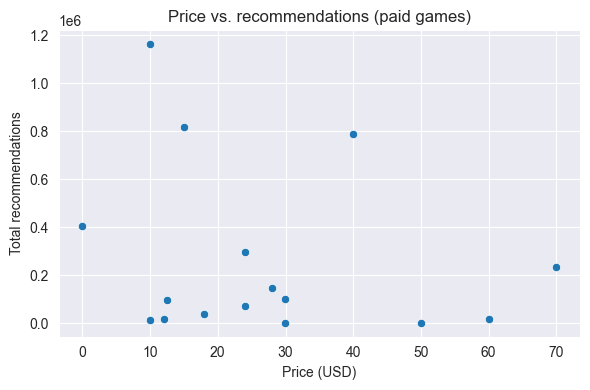

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Scatter plot: price vs recommendations (paid games only)
df_paid = df[df["free_or_paid"] == "Paid"].copy()

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_paid, x="price", y="recommendations")
plt.xlabel("Price (USD)")
plt.ylabel("Total recommendations")
plt.title("Price vs. recommendations (paid games)")
plt.tight_layout()
plt.show()

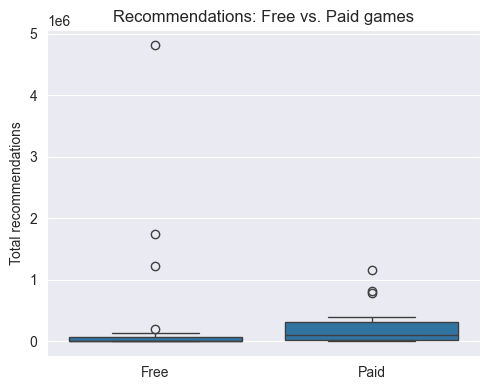

In [11]:
# 2) Boxplot: Free vs Paid recommendations
plt.figure(figsize=(5, 4))
sns.boxplot(data=df, x="free_or_paid", y="recommendations")
plt.xlabel("")
plt.ylabel("Total recommendations")
plt.title("Recommendations: Free vs. Paid games")
plt.tight_layout()
plt.show()

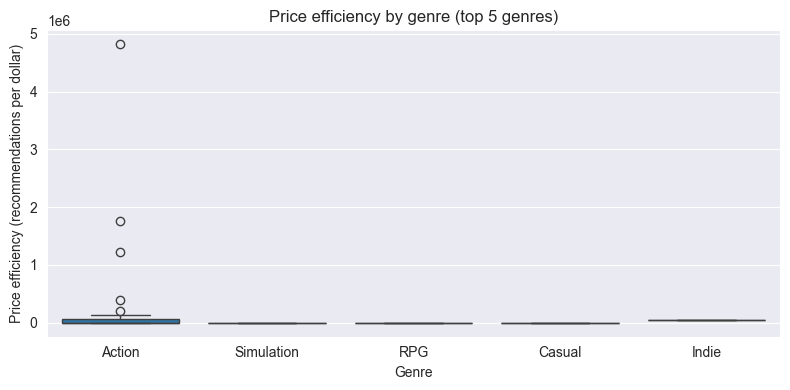

In [12]:
# 3) Boxplot: price_efficiency by genre
top_genres = df["genre"].value_counts().head(5).index
df_top_genres = df[df["genre"].isin(top_genres)].copy()

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_top_genres, x="genre", y="price_efficiency")
plt.xlabel("Genre")
plt.ylabel("Price efficiency (recommendations per dollar)")
plt.title("Price efficiency by genre (top 5 genres)")
plt.tight_layout()
plt.show()

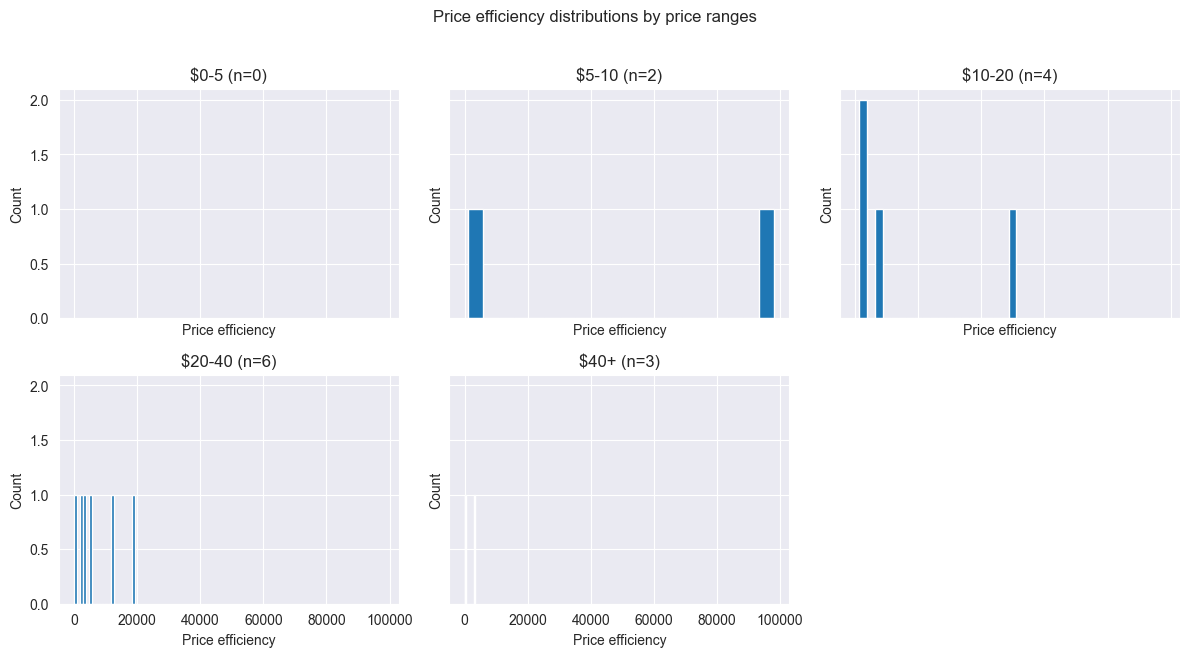

This figure presents a set of histograms showing the distribution of price efficiency across five price ranges: $0–5, $5–10, $10–20, $20–40, and $40+. Sample sizes are meaningful in most bins (n=9, 18, 42, 44, 25), which provides a reasonable basis for comparing distributional patterns across pricing tiers. The purpose of this analysis is to evaluate whether recommendation behavior (as summarized by price efficiency) varies systematically with price, and to identify whether lower- or higher-priced games tend to deliver greater “recommendation impact per dollar.
Strong right-skew across all price categories Across every price band, the histograms show highly right-skewed distributions. The mass of observations clusters near low price efficiency values, while a small subset of games exhibits very large efficiency. This pattern indicates that most games generate modest recommendation efficiency, while a limited number of titles produce exceptionally high performance relative to price. The

In [13]:
# Histogram: Distribution of efficiency values to illustrate how recommendation behavior varies across games prices.
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["price_efficiency"] = pd.to_numeric(df["price_efficiency"], errors="coerce")
df_paid = df[df["price"] > 0].copy()
pe_99 = df_paid["price_efficiency"].quantile(0.99)
df_paid["price_efficiency_clipped"] = df_paid["price_efficiency"].clip(upper=pe_99)

# Define price bins
bins = [0, 5, 10, 20, 40, 1000]
labels = ["$0-5", "$5-10", "$10-20", "$20-40", "$40+"]

df_paid["price_bin"] = pd.cut(
    df_paid["price"],
    bins=bins,
    labels=labels,
    right=False
)

# Grid setup
n = len(labels)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows), sharex=True, sharey=True)
axes = axes.flatten()

for i, label in enumerate(labels):
    ax = axes[i]
    sub = df_paid[df_paid["price_bin"] == label]
    ax.hist(sub["price_efficiency_clipped"].dropna(), bins=20)
    ax.set_title(f"{label} (n={len(sub)})")
    ax.set_xlabel("Price efficiency")
    ax.set_ylabel("Count")

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Price efficiency distributions by price ranges", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


print("This figure presents a set of histograms showing the distribution of price efficiency across five price ranges: $0–5, $5–10, $10–20, $20–40, and $40+. Sample sizes are meaningful in most bins (n=9, 18, 42, 44, 25), which provides a reasonable basis for comparing distributional patterns across pricing tiers. The purpose of this analysis is to evaluate whether recommendation behavior (as summarized by price efficiency) varies systematically with price, and to identify whether lower- or higher-priced games tend to deliver greater “recommendation impact per dollar.")
print("Strong right-skew across all price categories Across every price band, the histograms show highly right-skewed distributions. The mass of observations clusters near low price efficiency values, while a small subset of games exhibits very large efficiency. This pattern indicates that most games generate modest recommendation efficiency, while a limited number of titles produce exceptionally high performance relative to price. The presence of extreme values suggests that price efficiency is likely influenced by game-specific factors such as franchise popularity.")
print("The persistent right-skew across every tier indicates that price alone is insufficient to explain recommendation efficiency. While there may be mild differences in tail behavior across categories, the overall structure suggests that game quality, community effects, and genre-specific dynamics likely drive variation more strongly than price.")

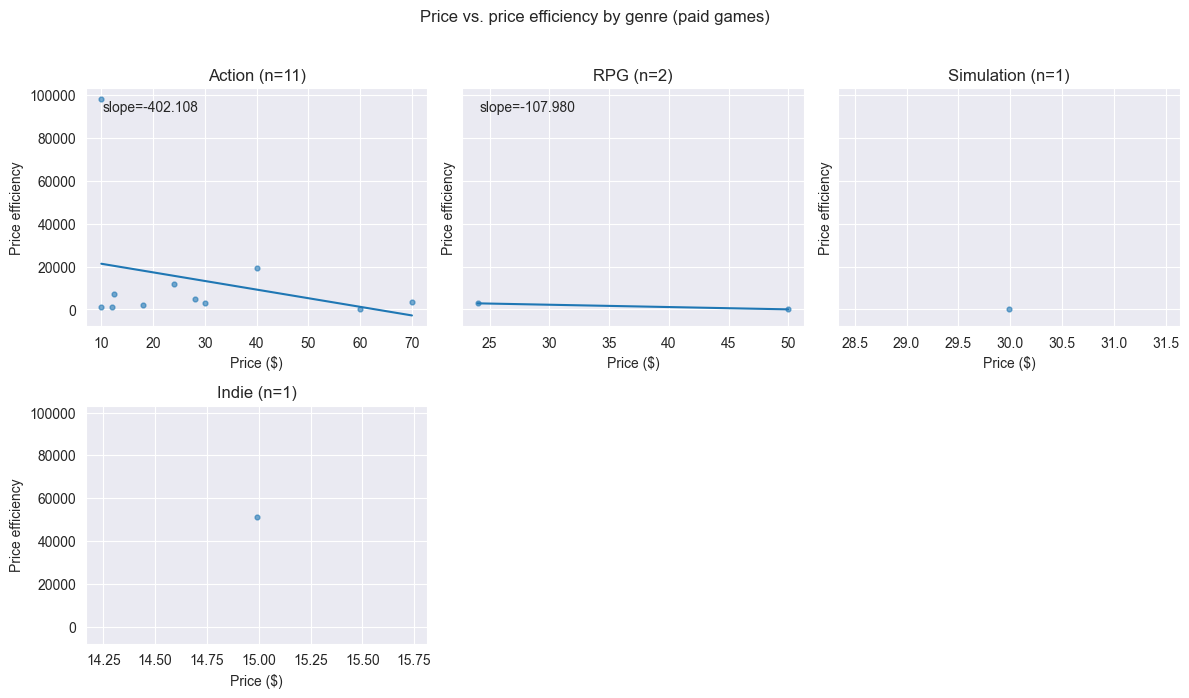

In smaller genres—Simulation (n=10), Indie (n=8), RPG (n=8), Adventure (n=8), and Casual (n=7)—the fitted lines suggest heterogeneous relationships. Indie, RPG, and Casual appear to show relatively steep negative slopes, while Adventure shows a mild positive slope. However, given the limited observations, these slopes may be sensitive to a few influential points and should be interpreted cautiously.
Overall, this figure provides evidence that higher prices are associated with higher price efficiency across genres. Instead, the dominant pattern suggests that higher-priced titles tend to yield lower recommendations per dollar


In [14]:
# Price vs efficiency by genre (scatter + simple linear fit) Plot the relationship between prices and recommendation efficiency in different genre to see whether recommendation efficiency is positively related to prices across different genres.
top_genres = df_paid["genre"].value_counts().head(6).index
df_g = df_paid[df_paid["genre"].isin(top_genres)].copy()

n = len(top_genres)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.4 * nrows), sharey=True)
axes = axes.flatten()

for i, genre in enumerate(top_genres):
    ax = axes[i]
    sub = df_g[df_g["genre"] == genre].dropna(subset=["price", "price_efficiency_clipped"])

    # Scatter
    ax.scatter(sub["price"], sub["price_efficiency_clipped"], s=12, alpha=0.6)

    # Simple linear fit line (only if enough points)
    if len(sub) >= 2:
        x = sub["price"].to_numpy()
        y = sub["price_efficiency_clipped"].to_numpy()

        # Fit
        slope, intercept = np.polyfit(x, y, 1)

        xs = np.linspace(x.min(), x.max(), 50)
        ys = intercept + slope * xs
        ax.plot(xs, ys)

        ax.text(
            0.05, 0.95,
            f"slope={slope:.3f}",
            transform=ax.transAxes,
            va="top"
        )

    ax.set_title(f"{genre} (n={len(sub)})")
    ax.set_xlabel("Price ($)")
    ax.set_ylabel("Price efficiency")

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Price vs. price efficiency by genre (paid games)", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()
print("In smaller genres—Simulation (n=10), Indie (n=8), RPG (n=8), Adventure (n=8), and Casual (n=7)—the fitted lines suggest heterogeneous relationships. Indie, RPG, and Casual appear to show relatively steep negative slopes, while Adventure shows a mild positive slope. However, given the limited observations, these slopes may be sensitive to a few influential points and should be interpreted cautiously.")
print("Overall, this figure provides evidence that higher prices are associated with higher price efficiency across genres. Instead, the dominant pattern suggests that higher-priced titles tend to yield lower recommendations per dollar")

# Likely reasons for results we get from obvious analysis
The patterns we observe—strong right-skew in price efficiency and mostly negative price–efficiency slopes across genres—can be explained by a combination of mechanical, behavioral, and market-structure factors. Lower-priced games benefit from reduced adoption friction. Players are more willing to experiment with inexpensive titles, and this low-risk purchase environment can generate disproportionately high “recommendations per dollar,” especially for games that exceed expectations relative to cost. Higher-priced games face elevated consumer expectations. Premium pricing often invites stricter evaluation, so even when expensive titles are popular in absolute terms, their value-normalized efficiency may performance worse than chip titles.